In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb

import ads

# to use ADSTuner
from ads.hpo.search_cv import ADSTuner
from ads.hpo.stopping_criterion import *
from ads.hpo.distributions import *

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

import time

import matplotlib.pyplot as plt

import pickle

%matplotlib inline

In [2]:
# check the ADS version
print(ads.__version__)

2.5.8


In [3]:
data = pd.read_csv('cs-training-nonull.csv')

# remove unneeded
data = data.drop('id', axis = 1)

In [4]:
# global constants
N_ESTIMATORS = 1000
# numero di features compreso le due colonne indicatore aggiunte
N_FEATURES = 12

# nome della colonna con le label
TARGET = 'SeriousDlqin2yrs'

# colonne con missing values
COL1_MISSING = 'MonthlyIncome'
COL2_MISSING = 'NumberOfDependents'

# nomi delle due colonne indicator (valgono 1 laddove il dato è inputato)
IND1 = 'isna_mi'
IND2 = 'isna_nod'

ind_col = [IND1, IND2]

# prese da stats sul train test, usate per inputare i missing values su COL1 e CL2
MONTHLY_INC_MEDIAN = 5400.0
N_OF_DEP_MODE = 0

In [5]:
train_df = data

In [6]:
# metto da parte le due colonne indicatori
ind_train = train_df[ind_col].values

In [7]:
train_df = train_df.drop(ind_col, axis = 1)

# estrae X: matrice features ed y, labels
y_train = train_df[TARGET].values
xtrain_df = train_df.drop(TARGET, axis = 1)
x_train = xtrain_df.values

In [8]:
# prepara lo scaling
scaler = StandardScaler()

# calcola i parametri di scaling solo sul train set
scaler.fit(x_train)

StandardScaler()

In [9]:
# scalo tutto tranne che le due colonne indicatore
x_train_scaled = scaler.transform(x_train)

In [10]:
# riaggiungo gli indicatori (che non vengono scalati)
x_train_scaled = np.c_[x_train_scaled, ind_train]

In [11]:
# check
assert x_train_scaled.shape[1] == N_FEATURES

### Train the XGBoost Classifier

In [12]:
# parameters for the HPO session with Optuna
FOLDS = 5
SEED = 4321

N_TRIALS = 100
TIME_BUDGET = 7200
STUDY_NAME = "xgb01"

# ranges
LR_LOW = 1e-3
LR_HIGH = 1e-2
DEPTH_LOW = 4
DEPTH_HIGH = 8
N_ITER_LIST = [300, 400, 500, 600, 700, 800, 900, 1000]

In [13]:
#
# Here we define the strategy, the space for hyper-parameters we want to explore
#
params = {
    "n_estimators": CategoricalDistribution(N_ITER_LIST),
    "learning_rate": LogUniformDistribution(low=LR_LOW, high=LR_HIGH),
    "max_depth": IntUniformDistribution(DEPTH_LOW, DEPTH_HIGH),
}

clf = xgb.XGBClassifier()


# per lista scorer sorted(sklearn.metrics.SCORERS.keys())
tuner = ADSTuner(clf, cv=FOLDS, strategy=params, scoring="roc_auc", study_name=STUDY_NAME, n_jobs=6)

tuner.tune(x_train, y_train, exit_criterion=[TimeBudget(TIME_BUDGET)])

[I 2022-03-14 15:48:14,773] A new study created in RDB with name: xgb01


In [94]:
# get the status to see if completed
print(f"The tuner status is: {tuner.get_status()}")

print(f"Remaining time is: {round(tuner.time_remaining, 1)} sec.")

The tuner status is: State.RUNNING
Remaining time is: 0 sec.


In [95]:
# look only at completed trials, sorted with best on top. Metric chosen is in the value col.
result_df = tuner.trials[tuner.trials["state"] == "COMPLETE"].sort_values(
    by=["value"], ascending=False
)

result_df.head(10)

,number,value,datetime_start,datetime_complete,duration,params_learning_rate,params_max_depth,params_n_estimators,user_attrs_mean_fit_time,user_attrs_mean_score_time,...,user_attrs_metric,user_attrs_split0_test_score,user_attrs_split1_test_score,user_attrs_split2_test_score,user_attrs_split3_test_score,user_attrs_split4_test_score,user_attrs_std_fit_time,user_attrs_std_score_time,user_attrs_std_test_score,state
92,92,0.865046,2022-03-14 17:23:44.206469,2022-03-14 17:31:39.771706,0 days 00:07:55.565237,0.009362,6,1000,95.001051,0.064436,...,roc_auc,0.863150,0.860687,0.865491,0.864702,0.871197,0.225618,0.002663,0.003486,COMPLETE
56,56,0.865045,2022-03-14 16:39:44.791926,2022-03-14 16:47:44.594435,0 days 00:07:59.802509,0.008979,6,1000,95.848110,0.064791,...,roc_auc,0.863226,0.860316,0.865730,0.864793,0.871160,0.297359,0.002657,0.003566,COMPLETE
72,72,0.865024,2022-03-14 16:55:46.263603,2022-03-14 17:03:39.473152,0 days 00:07:53.209549,0.009665,6,1000,94.527511,0.067095,...,roc_auc,0.863086,0.860640,0.865500,0.864668,0.871225,0.317624,0.004679,0.003515,COMPLETE
105,105,0.865021,2022-03-14 17:35:53.415843,2022-03-14 17:43:47.826966,0 days 00:07:54.411123,0.009247,6,1000,94.767534,0.066314,...,roc_auc,0.863140,0.860516,0.865702,0.864579,0.871168,0.443686,0.001773,0.003529,COMPLETE
97,97,0.865015,2022-03-14 17:25:43.476847,2022-03-14 17:33:41.878161,0 days 00:07:58.401314,0.009290,6,1000,95.565484,0.067089,...,roc_auc,0.863277,0.860375,0.865523,0.864717,0.871185,1.148139,0.005128,0.003549,COMPLETE
107,107,0.865014,2022-03-14 17:40:48.837952,2022-03-14 17:48:44.727379,0 days 00:07:55.889427,0.008810,6,1000,95.061220,0.069173,...,roc_auc,0.863276,0.860553,0.865416,0.864719,0.871105,0.253211,0.006422,0.003472,COMPLETE
110,110,0.864989,2022-03-14 17:43:29.456472,2022-03-14 17:50:48.813443,0 days 00:07:19.356971,0.009295,6,1000,87.763003,0.064271,...,roc_auc,0.863207,0.860481,0.865463,0.864743,0.871051,10.362846,0.006877,0.003480,COMPLETE
109,109,0.864986,2022-03-14 17:41:39.706274,2022-03-14 17:49:29.804452,0 days 00:07:50.098178,0.009164,6,1000,93.907661,0.063383,...,roc_auc,0.863082,0.860732,0.865567,0.864527,0.871024,2.847114,0.002984,0.003427,COMPLETE
41,41,0.864985,2022-03-14 16:24:46.625592,2022-03-14 16:32:46.582688,0 days 00:07:59.957096,0.008286,6,1000,95.871545,0.071143,...,roc_auc,0.863188,0.860534,0.865482,0.864646,0.871077,0.391903,0.004281,0.003479,COMPLETE
87,87,0.864984,2022-03-14 17:17:32.848082,2022-03-14 17:25:29.668256,0 days 00:07:56.820174,0.008512,6,1000,95.247697,0.069719,...,roc_auc,0.863138,0.860597,0.865299,0.864735,0.871150,0.394359,0.002800,0.003488,COMPLETE


In [99]:
def show_tuner_results(tuner):

    # to count completed
    result_df = tuner.trials[tuner.trials["state"] == "COMPLETE"].sort_values(
        by=["value"], ascending=False
    )

    print("ADSTuner session results:")
    print(f"ADSTuner has launched {tuner.trials.shape[0]} trials")
    print(f"ADSTuner has completed {result_df.shape[0]} trials")
    print()
    print(f"The best trial is the #: {tuner.best_index}")
    print(f"Parameters for the best trial are: {tuner.best_params}")
    print(f"The metric used to optimize is: {tuner.scoring_name}")
    print(f"The best score is: {round(tuner.best_score, 4)}")
    
show_tuner_results(tuner)

ADSTuner session results:
ADSTuner has launched 113 trials
ADSTuner has completed 112 trials

The best trial is the #: 92
Parameters for the best trial are: {'learning_rate': 0.00936168846881555, 'max_depth': 6, 'n_estimators': 1000}
The metric used to optimize is: roc_auc
The best score is: 0.865


### Train with best params

In [100]:
%%time

clf = xgb.XGBClassifier(**tuner.best_params)

# addestro e valuto su train e su validation set
clf.fit(x_train_scaled, y_train,
        eval_set=[(x_train_scaled, y_train)],
        eval_metric='auc', verbose=100)

print()

evals_result = clf.evals_result()

[0]	validation_0-auc:0.84995
[100]	validation_0-auc:0.85784
[200]	validation_0-auc:0.86059
[300]	validation_0-auc:0.86617
[400]	validation_0-auc:0.87017
[500]	validation_0-auc:0.87416
[600]	validation_0-auc:0.87757
[700]	validation_0-auc:0.88017
[800]	validation_0-auc:0.88189
[900]	validation_0-auc:0.88329
[999]	validation_0-auc:0.88416

CPU times: user 2h 59min 41s, sys: 48.4 s, total: 3h 29s
Wall time: 8min 24s


#### OK, consider that the slightly higher AUC is due to the fact here we're evaluating also on train data

In [101]:
def plot_auc(train_hist):
    plt.figure(figsize=(9,6))
    
    plt.plot(train_hist, label='Training AUC')
    plt.title('AUC')
    plt.legend(loc='lower right')
    plt.ylabel('auc')
    plt.xlabel('n_estimator')
    plt.grid(True)
    plt.show();

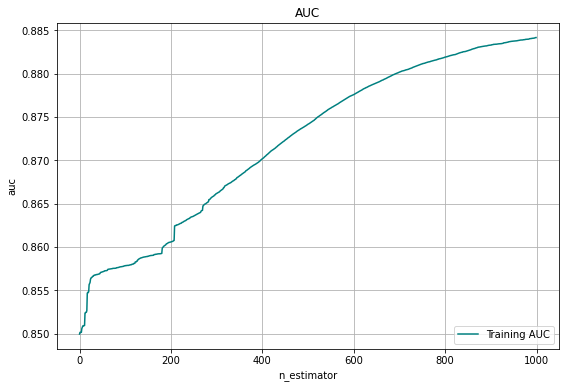

In [102]:
train_hist = evals_result['validation_0']['auc']

plot_auc(train_hist)

In [103]:
# compute accuracy on train_set
y_pred = clf.predict(x_train_scaled)

predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_train, predictions)

print("Accuracy on train set: %.2f%%" % (accuracy * 100.0))

Accuracy on train set: 94.29%


In [104]:
# compute confusion matrix
tn, fp, fn, tp = confusion_matrix(y_train, predictions).ravel()

(tn, fp, fn, tp)

(139063, 911, 7658, 2368)

### Prediction on the TEST set (for submission to Kaggle)

In [ ]:
# predictions on test set
orig_test = pd.read_csv('cs-test.csv')

# inpute missing values, add the two indicator columns
orig_test['isna_mi'] = 0
orig_test.loc[orig_test[COL1_MISSING].isna(), 'isna_mi'] = 1
orig_test.loc[orig_test[COL1_MISSING].isna(), COL1_MISSING] = MONTHLY_INC_MEDIAN

orig_test['isna_nod'] = 0
orig_test.loc[orig_test[COL2_MISSING].isna(), 'isna_nod'] = 1
orig_test.loc[orig_test[COL2_MISSING].isna(), COL2_MISSING] = N_OF_DEP_MODE

In [ ]:
ind_test = orig_test[ind_col].values

In [ ]:
orig_test = orig_test.drop(ind_col, axis = 1)

In [ ]:
ID_COL_NAME = 'Unnamed: 0'
xorig_test = orig_test.drop(ID_COL_NAME, axis = 1)
xorig_test = xorig_test.drop(TARGET, axis = 1)

x_test = xorig_test.values

In [ ]:
# aggiungi qui lo scaling !!!
x_test_scaled = scaler.transform(x_test)
# riaggiunge le colonne indicatore
x_test_scaled = np.c_[x_test_scaled, ind_test]

assert x_test_scaled.shape[1] == N_FEATURES

In [ ]:
# do predictions on test set (no shuffle !)
y_pred = clf.predict_proba(x_test_scaled)

# y_pred contiene le probabilità
y_pred = y_pred[:, 1]

In [ ]:
# prepara il csv per la submission
result_dict = {"Id": orig_test[ID_COL_NAME].values,
              'Probability': y_pred}

FILE_SUB = 'submission25.csv'

# build a dataframe and save to csv
result_df = pd.DataFrame(result_dict)

result_df.to_csv(FILE_SUB, index=False, float_format='%.5f')

In [ ]:
### Save Modela and scaler

In [ ]:
# save model: uso un formato semplice: pkl
pickle.dump(clf, open("credit-scoring.pkl", "wb"))

In [ ]:
# salvo anche lo scaler
pickle.dump(scaler, open("scaler.pkl", "wb"))

### Online predictions

In [ ]:
# reload the model
loaded_model = pickle.load(open("credit-scoring.pkl", "rb"))

In [ ]:
# reload the scaler
loaded_scaler = pickle.load(open("scaler.pkl", "rb"))

In [ ]:
# prepare for online predictions
# input are given as a numpy array, with no missing fields, but we need to add the two indicator columns
x_input = np.array([[1,2,3,4,5,6,7,8,9,10],
                   [1,2,3,4,5,6,7,8,9,10],
                   [1,2,3,4,5,6,7,8,9,10]])

In [ ]:
# controlli
assert x_input.shape[1] == 10
# check there are no null
assert np.sum(np.isnan(x_input)) == 0

In [ ]:
# normalize
x_input_scaled = loaded_scaler.transform(x_input)

# add two columns with 0
x_add = np.zeros((x_input.shape[0], 2))
x_input_scaled = np.c_[x_input_scaled, x_add]

In [ ]:
y_pred = loaded_model.predict(x_input_scaled)

In [ ]:
y_pred

In [ ]:
train_df[TARGET].hist();